# 1. Introduction
This notebook explains how to use a neural solver (DiffNet) to solve the Poisson PDE in 3D. However, instead of explicitly coding the solution, the technique used here consists of calling a REST-based server that accepts equation parameters as inputs, performs inference on a pre-trained model, and returns the PDE solution as output. The goal is to demonstrate the use of inference engines as fast PDE solvers in a minimal-code environment.

## The Poisson equation
The Poisson equation for the scalar field $u({\bf x})$ can be written as

$$
-\nabla \cdot (\nu({\bf x}) \nabla u({\bf x})) = f({\bf x}) \textrm{ in } D,
$$

where $\nu({\bf x})$ represents the *diffusivity* (or *permeability*) of the medium. Without loss of generality, we consider the homogeneous case where $f({\bf x}) = 0$, and impose the following boundary conditions assuming that $D$ is the unit cube:

\begin{cases}
 & u(0, y, z) = 1, \\
 & u(1, y, z) = 0, \\
 & \frac{\partial u}{\partial n} = 0 \textrm{ on other boundaries }
\end{cases}

The diffusivity map $\nu({\bf x})$ can be any function and, in the DiffNet scheme, constitutes the input to the neural network. The output of the network will be the solution $u({\bf x})$ to the Poisson PDE.

## The RML inference server
The inference server is the engine that accepts diffusivity maps as inputs, performs an inference using a pre-trained DiffNet model, and returns the network output as the Poisson PDE solution. The architecture of the server is depicted in the figure below. It is composed of three main modules:

- A REST-based interface to handle client requests
- A job queue of inference requests received by the REST interface, which are executed when resources are available
- A thread pool that consumes instances from the queue and executes them

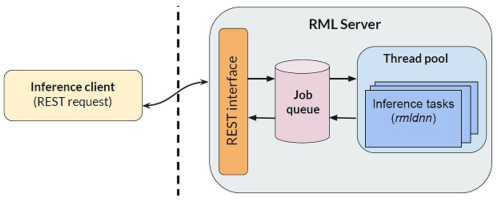



# 2. Dependencies

The few packages needed are loaded next. Notice that we use `requests` to handle the REST-based communication with the server. `Keras` and `Tensorflow` are only needed to visualize the DiffNet neural network, and can optionally be skipped. 

In [1]:
import os
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
from keras.models import model_from_json # Only for network visualization
from tensorflow.keras.utils import plot_model # Only for network visualization

# 3. Configuration

## Helper functions
The helper function `create_request()` creates the body of the request to be sent to the server. It consists of a JSON string containing the path to the input `numpy` data (diffusivity map), the path to the network description file (in `Keras` format), and the path to the pre-trained model. 

In [2]:
# Generate application JSON configuration
def create_request(model, network, sample, batch_size=1):
    config = {
        "neural_network": {
            "checkpoints": {
                "load": model
            },
            "data": {
                "type": "numpy",
                "test_input_path" : sample,
                "test_target_path": sample,
                "test_batch_size": batch_size
            },
            "loss": {
                "function": "Poisson3d_PDE"
            },
            "layers": network
        }
    }
    
    return json.dumps(config)

The helper function `display_slice()` simply plots the datasets passed in. It will be used to compare the result of DiffNet against the corresponding FEM-based solution for a given diffusivity map.

In [3]:
def display_slice(nu, pred, truth):
    fig, ax = plt.subplots(1, 4, figsize=[18, 18])
    #fig.suptitle('Vertically stacked subplots')
    ax[0].set_title('Input')
    im0 = ax[0].imshow(nu, origin='lower', cmap='jet')
    ax[1].set_title('DiffNet')
    im1 = ax[1].imshow(pred, origin='lower', cmap='jet') #, vmin=0, vmax=1
    ax[2].set_title('FEM')
    im2 = ax[2].imshow(truth, origin='lower', cmap='jet') #, vmin=0, vmax=1
    ax[3].set_title('Error')
    im3 = ax[3].imshow(pred - truth, origin='lower', cmap='jet')
    fig.colorbar(im0, ax = ax[0], shrink=0.2)
    fig.colorbar(im1, ax = ax[1], shrink=0.2)
    fig.colorbar(im2, ax = ax[2], shrink=0.2)
    fig.colorbar(im3, ax = ax[3], shrink=0.2)
    plt.show()    

## Input parameters

The following cell defines the paths to the pre-trained model, network file, and input sample as a `numpy` file (these are paths on the server).

In [4]:
model   = '/home/ubuntu/models/model_checkpoint_64x64x64_ep50.pt'
network = '/home/ubuntu/networks/unet3d_64x64x64.json'
sample  = '/home/ubuntu/data/nu.npy'

The following two cells are optional: we visualilze the DiffNet network, which has a 2D Unet architecture.
Next, we plot a slice across the input diffusivity map.

In [ ]:
model_json = open('/home/ubuntu/networks/unet3d_64x64x64_keras.json', 'r').read()
keras_model = model_from_json(model_json)
plot_model(keras_model, show_shapes=True)

(1, 64, 64, 64)


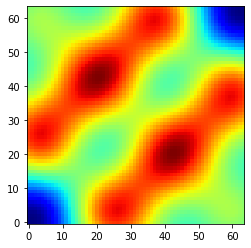

In [6]:
diff_map = np.load(sample)
print(diff_map.shape)
plt.imshow(diff_map[0, 32, :, :], origin='lower', cmap='jet')

# 4. Execution

## Performing inference
The following cell finally solves the Poisson equation by sending a request to the inference server. Both request and response are JSON strings. The request string is composed using the `create_request()` function defined above. The number `60000` in the REST command indicates the number of milli-seconds we're willing to wait to get the result back in the same call. If the run takes longer than this, the call will return while the inference is still running, and we'll have to call later to fetch the result.

In [7]:
# Send request to server
response = requests.post('http://127.0.0.1:9080/run/dnn/60000', create_request(model, network, sample))
data = response.json()
data.keys()

dict_keys(['status', 'job_id', 'job_state', 'exit_code', 'output'])

## Parsing the result

The response from the server contains the following keys:
- **status**: whether the request was successful
- **job_id**: the ID of the inference job
- **job_state**: whether the job is queued, running or completed
- **exit_code**: exit code of the inference run itself
- **output**: the output of the network, if inference is successfull. This object contains a list of `tensor`s with one element for each input passed in. Each `tensor` has the following fields:
  - **dims**: Array of tensor dimensions
  - **values**: A flattened 1D array with the tensor values  

In [8]:
print(f" Status = {data['status']}\n Job ID = {data['job_id']}\n Job state = {data['job_state']}\n Exit code = {data['exit_code']}")
if (data['exit_code'] != 0):
    print(f"   Reason = {data['output']}")

 Status = ok
 Job ID = 2
 Job state = done
 Exit code = 0


In [9]:
print(f"Num predictions = {len(data['output']['tensors'])}")
tensor = data['output']['tensors'][0]
print(f"dims = {tensor['dims']}")

Num predictions = 1
dims = [1, 1, 64, 64, 64]


Finally, we reshape the flat array to recover the tensor, and squeeze out the dimensions of size 1. What remains is the solution to the Poisson PDE, i.e., $u(x,y,z)$:

In [10]:
pred = np.asarray(tensor['values']).reshape(tensor['dims']).squeeze()
print(pred.shape)

(64, 64, 64)


## Analyzing the results
Finally, we can plot slices across the DiffNet prediction and compare to the corresponding solution via the FEM method (previously computed).

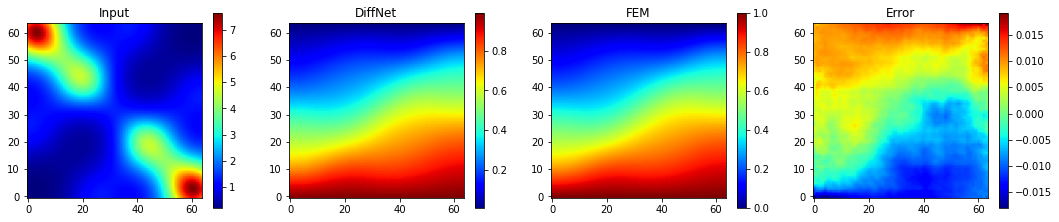

In [11]:
fem_solution = np.load('/home/ubuntu/data/fem.npy')
nu = np.load(sample)
x = 48
display_slice(nu[0, :, x, :], pred[:, x, :], fem_solution[:, x, :])